# In-place transposition

An interesting example problem for which to look at cache effects is [in-place matrix transposition](https://en.wikipedia.org/wiki/In-place_matrix_transposition).  Specifically, we will look at *square* matrices — the non-square case is [*much* more tricky](https://en.wikipedia.org/wiki/In-place_matrix_transposition#Non-square_matrices:_Following_the_cycles).

## Two-loop implementation:

Let's begin by implementing a simple in-place `transpose!(A)` routine for square matrices:

In [48]:
function Base.transpose!(A)
    m = LinAlg.checksquare(A)
    for i = 1:m, j=i+1:m
        A[i,j], A[j,i] = A[j,i], A[i,j]
    end
    return A
end

Of course, we should check that it is correct:

In [2]:
A = rand(5,5)
transpose(A) == transpose!(copy(A))

true

Now, let's benchmark it for $n \times n$ matrices with sizes $n=2^k$ and $n=2^k+1$.  It turns out that there is an interesting difference in performances:

In [3]:
using PyPlot, BenchmarkTools

In [49]:
N = 2.^(4:1:14)
t = Float64[]
t1 = Float64[]
for n in N
    A = zeros(n,n)
    push!(t, @belapsed(transpose!(A), evals=max(2,(100÷n)^2)))
    A = zeros(n+1,n+1)
    push!(t1, @belapsed(transpose!(A), evals=max(2,(100÷n)^2)))
    println("n = $n, ratio = ", t[end]/t1[end])
    flush(STDOUT)
end

n = 16, ratio = 0.896677966101695
n = 32, ratio = 0.7603716162101554
n = 64, ratio = 1.0166552589550537
n = 128, ratio = 1.826369762672136
n = 256, ratio = 6.04446570572643
n = 512, ratio = 3.6430582555318733
n = 1024, ratio = 4.533394288924537
n = 2048, ratio = 3.3344110095268755
n = 4096, ratio = 4.330792852917974
n = 8192, ratio = 3.5924179697554153
n = 16384, ratio = 2.7195677691719453


In particular, since the time might naively be expected to be proportional to $n^2$ (the number of data moves or loop iterations), let's plot $\mathrm{time}/n^2$ versus $n$:

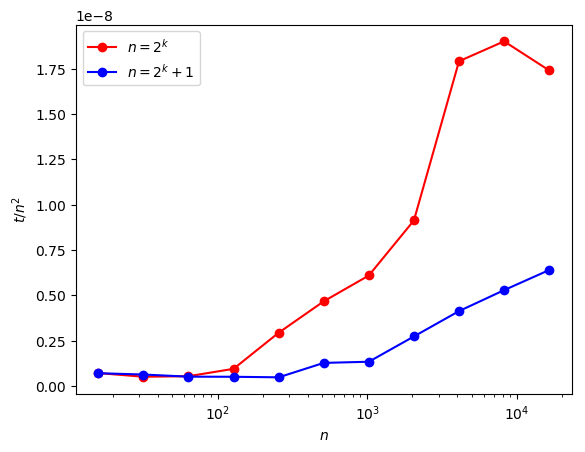

PyObject Text(29.6,0.5,u'$t / n^2$')

In [50]:
semilogx(N, t ./ N.^2, "ro-")
semilogx(N, t1 ./ (N.+1).^2, "bo-")
legend([L"n=2^k", L"n=2^k+1"])
xlabel(L"n")
ylabel(L"t / n^2")

There are several interesting things to see here, due **purely to memory effects**:

* $t/n^2$ is *not* a constant: the time increases dramatically when the matrix becomes large enough to go out of cache. 

* Large power-of-two sizes are significantly slower (about 4 times slower!) than adjacent odd sizes.  This is related to the [associativity of the cache](https://en.wikipedia.org/wiki/CPU_cache).  For power-of-two sizes, going from one column to the next goes by a power-of-two number of bytes in memory.  Two memory locations that differ by a large power of two are mapped to the *same* set of cache lines.  So, **power-of-two strides in memory effectively "see" a smaller cache**.

Note that this problem has *no temporal locality*: each off-diagonal matrix element is read exactly once.   So, once the whole matrix no longer fits in cache (recall that BenchmarkTools typically benchmarks multiple times), the only thing that matters is *spatial locality* (cache line utilization).

## Recursive (cache-oblivious) transpose

A nice idea to improve performance is a recursive algorithm, which divides the matrix into four pieces and transposes/swaps them recursively (depth first).  For an early discussion of this idea, which is an example of a [cache-oblivious algorithm](https://en.wikipedia.org/wiki/Cache-oblivious_algorithm), see e.g.

* M. Frigo, C. Leiserson, H. Prokop, S. Ramachandran, [Cache-oblivious algorithms](http://supertech.csail.mit.edu/papers/FrigoLePr99.pdf), *Proc. IEEE Symp. on Foundations of Computer Science* (FOCS), pp. 285–297 (1999).

Here are two possible implementations of this idea.  The first one passes explicit indices/sizes to itself recursively to indicate the locations/sizes of the submatrices to transpose or swap.  The second uses [views](https://docs.julialang.org/en/stable/manual/performance-tips/#Consider-using-views-for-slices-1) of the original array to more concisely describe the subarrays, at the price of allocating a small view object (on the heap in Julia 0.6, or on the stack in Julia 0.7).

Note that we need to use a base case of a significant size to make sure the overhead of recursion is negligible.

In [39]:
rtranspose!(A) = rtranspose!(A, 1, LinAlg.checksquare(A))
function rtranspose!(A, istart,m)
    if m < 128
        iend = istart + m - 1
        for i = istart:iend, j = i+1:iend
            A[i,j], A[j,i] = A[j,i], A[i,j]
        end
    else
        m2 = m >> 1
        rtranspose!(A, istart,m2)
        rtranspose!(A, istart+m2, m-m2)
        rswap!(A, istart,istart+m2, m2,m-m2)
    end
    return A
end
function rswap!(A, istart,jstart, m,n)
    if m+n < 256
        iend = istart+m-1
        jend = jstart+n-1
        for i=istart:iend, j=jstart:jend
            A[i,j], A[j,i] = A[j,i], A[i,j]
        end
    else
        m2 = m >> 1
        n2 = n >> 1
        rswap!(A, istart,jstart, m2,n2)
        rswap!(A, istart+m2,jstart, m-m2,n2)
        rswap!(A, istart,jstart+n2, m2,n-n2)
        rswap!(A, istart+m2,jstart+n2, m-m2,n-n2)
    end
end

rswap! (generic function with 1 method)

In [38]:
function rvtranspose!(A)
    m = size(A, 1)
    if m < 128
        for i = 1:m, j = i+1:m
            A[i,j], A[j,i] = A[j,i], A[i,j]
        end
    else
        m2 = m >> 1
        @views rvtranspose!(A[1:m2,1:m2])
        @views rvtranspose!(A[m2+1:m, m2+1:m])
        @views rvswap!(A[1:m2,m2+1:m], A[m2+1:m,1:m2])
    end
    return A
end
function rvswap!(A, B)
    m, n = size(A) # B must be n by m!
    if m+n < 256
        for i=1:m, j=1:n
            A[i,j], B[j,i] = B[j,i], A[i,j]
        end
    else
        m2 = m >> 1
        n2 = n >> 1
        @views rvswap!(A[1:m2,1:n2], B[1:n2,1:m2])
        @views rvswap!(A[m2+1:m,1:n2], B[1:n2,m2+1:m])
        @views rvswap!(A[1:m2,n2+1:n], B[n2+1:n,1:m2])
        @views rvswap!(A[m2+1:m,n2+1:n], B[n2+1:n,m2+1:m])
    end
end

rvswap! (generic function with 1 method)

In [28]:
A = rand(1001,1001)
rtranspose!(copy(A)) == transpose(A) == rvtranspose!(copy(A))

true

In [51]:
rt = Float64[]
rt1 = Float64[]
for n in N
    A = zeros(n,n)
    push!(rt, @belapsed(rtranspose!(A), evals=max(2,(100÷n)^2)))
    A = zeros(n+1,n+1)
    push!(rt1, @belapsed(rtranspose!(A), evals=max(2,(100÷n)^2)))
    println("n = $n, speedup = ", t1[length(rt1)]/rt1[end])
    flush(STDOUT)
end

n = 16, speedup = 1.0119374313940723
n = 32, speedup = 1.128728982100886
n = 64, speedup = 1.016465677179963
n = 128, speedup = 1.004473482841839
n = 256, speedup = 1.0005492608518252
n = 512, speedup = 0.9363824130338199
n = 1024, speedup = 0.7452510889184982
n = 2048, speedup = 1.119255055792567
n = 4096, speedup = 1.5170199988837978
n = 8192, speedup = 1.789626637099851
n = 16384, speedup = 2.419710816289696


In [52]:
rvt = Float64[]
rvt1 = Float64[]
for n in N
    A = zeros(n,n)
    push!(rvt, @belapsed(rvtranspose!(A), evals=max(2,(100÷n)^2)))
    A = zeros(n+1,n+1)
    push!(rvt1, @belapsed(rvtranspose!(A), evals=max(2,(100÷n)^2)))
    println("n = $n, speedup = ", t1[length(rvt1)]/rvt1[end])
    flush(STDOUT)
end

n = 16, speedup = 1.2866364270760642
n = 32, speedup = 1.200576923076923
n = 64, speedup = 0.9746497665110073
n = 128, speedup = 0.3863831906896708
n = 256, speedup = 0.3362994767490928
n = 512, speedup = 0.7446969235455376
n = 1024, speedup = 0.5045123663315704
n = 2048, speedup = 0.6293099811392953
n = 4096, speedup = 0.8440415592098159
n = 8192, speedup = 0.9865210168956932
n = 16384, speedup = 1.6179828394304216


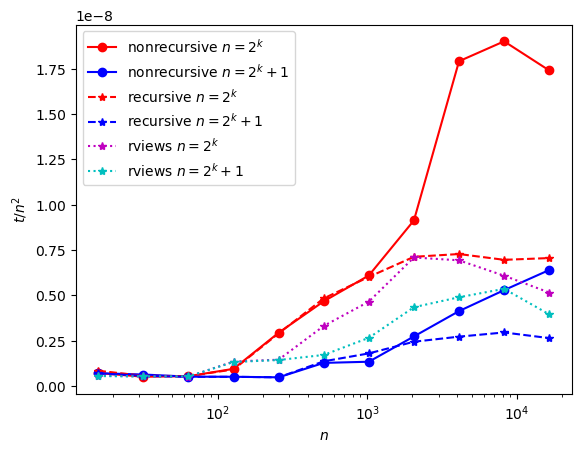

PyObject Text(29.6,0.5,u'$t / n^2$')

In [53]:
semilogx(N, t ./ N.^2, "ro-")
semilogx(N, t1 ./ (N.+1).^2, "bo-")
semilogx(N, rt ./ N.^2, "r*--")
semilogx(N, rt1 ./ (N.+1).^2, "b*--")
semilogx(N, rvt ./ N.^2, "m*:")
semilogx(N, rvt1 ./ (N.+1).^2, "c*:")
legend([L"nonrecursive $n=2^k$", L"nonrecursive $n=2^k+1$",
        L"recursive $n=2^k$", L"recursive $n=2^k+1$",
        L"rviews $n=2^k$", L"rviews $n=2^k+1$"])
xlabel(L"n")
ylabel(L"t / n^2")

The cache-oblivious algorithm significantly improves performance for large sizes, although there is naturally still a slowdown once the matrix no longer fits in cache.

Mysteriously, the view version is actually slightly faster than the passing-indices version for power-of-two sizes.  I don't have an explanation for that at the moment.

Lots of other things could be tried.   You could get a bit more speed by passing `@inbounds` to turn off bounds checking.   You could try an explicitly "blocked" algorithm, e.g. using $8\times 8$ blocks in hopes of taking advantage of the typical 64-byte cache lines.  You could try using multiple threads (which are especially tricky to benefit from because of the cache contention that can arise in transpose's memory-access pattern).